# Make a plots of cloud radiative effects

There are radiative fluxes at TOA and the surface that are observed and modelled in CanAM.  This plot will summarize them using matplotlib to generate the graphs and compute the averages for the cloud radiative effects.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as py
from cdo import *
import os

Function to compute the required satellite data

In [2]:
def get_ebaf_obs(start_year,
                 end_year,
                 file_ebaf,
                 file_target_grid):
    
    # Get the observations and average them
    print("get_ebaf_obs")
    
    # Read in the observational data and compute the global means
    ofile1="temp_file1.nc"
    ofile2="temp_file2.nc"
    
    print("remapcon")
    cdo.remapcon(file_target_grid, input = file_ebaf, output=ofile1)
    print("zonmean")
    cdo.zonmean(input = ofile1, output=ofile2) #returnXDataset = True)
    
    ds_zonal_mean = xr.open_dataset(ofile2)
    
    # Compute the time mean from start_year to end_year
    text1='{0}-01-01'
    text2='{0}-12-31'
    year1=text1.format(start_year)
    year2=text2.format(end_year)
    
    ds_zonal_ann_mean = ds_zonal_mean.sel(time=slice(year1, year2)).mean('time')
    
    # While it is better to have a XArray dataset, I don't want the plotting routine to
    # bother with specifics of the dataset, so put the scalar values the plot needs into
    # an array and return that.  This should make it easier to generate the plot using
    # different data sources.
    
    # Ordered as LW, SW, LW+SW, all net
    lat = ds_zonal_ann_mean.lat.data
    nlat = np.size(lat)
    
    cre_atm = np.zeros([nlat,3])
    cre_toa = np.zeros([nlat,3])
    cre_sfc = np.zeros([nlat,3])

    flx_all_dn_lw_t = 0.0
    flx_all_up_lw_t = ds_zonal_ann_mean.toa_lw_all_mon.data
    flx_all_dn_sw_t = ds_zonal_ann_mean.solar_mon.data
    flx_all_up_sw_t = ds_zonal_ann_mean.toa_sw_all_mon.data

    flx_clr_dn_lw_t = 0.0
    flx_clr_up_lw_t = ds_zonal_ann_mean.toa_lw_clr_t_mon.data
    flx_clr_dn_sw_t = ds_zonal_ann_mean.solar_mon.data
    flx_clr_up_sw_t = ds_zonal_ann_mean.toa_sw_clr_t_mon.data
    
    cre_toa[:,0] = (flx_all_dn_lw_t-flx_all_up_lw_t[:,0])-(flx_clr_dn_lw_t-flx_clr_up_lw_t[:,0])
    cre_toa[:,1] = (flx_all_dn_sw_t[:,0]-flx_all_up_sw_t[:,0])-(flx_clr_dn_sw_t[:,0]-flx_clr_up_sw_t[:,0])
    cre_toa[:,2] = cre_toa[:,0]+cre_toa[:,1]
    
    flx_all_dn_lw_s = ds_zonal_ann_mean.sfc_lw_down_all_mon.data
    flx_all_up_lw_s = ds_zonal_ann_mean.sfc_lw_up_all_mon.data
    flx_all_dn_sw_s = ds_zonal_ann_mean.sfc_sw_down_all_mon.data
    flx_all_up_sw_s = ds_zonal_ann_mean.sfc_sw_up_all_mon.data

    flx_clr_dn_lw_s = ds_zonal_ann_mean.sfc_lw_down_clr_t_mon.data
    flx_clr_up_lw_s = ds_zonal_ann_mean.sfc_lw_up_clr_t_mon.data
    flx_clr_dn_sw_s = ds_zonal_ann_mean.sfc_sw_down_clr_t_mon.data
    flx_clr_up_sw_s = ds_zonal_ann_mean.sfc_sw_up_clr_t_mon.data

    cre_sfc[:,0] = (flx_all_dn_lw_s[:,0]-flx_all_up_lw_s[:,0])-(flx_clr_dn_lw_s[:,0]-flx_clr_up_lw_s[:,0])
    cre_sfc[:,1] = (flx_all_dn_sw_s[:,0]-flx_all_up_sw_s[:,0])-(flx_clr_dn_sw_s[:,0]-flx_clr_up_sw_s[:,0])
    cre_sfc[:,2] = cre_sfc[:,0]+cre_sfc[:,1]

    cre_atm = cre_toa-cre_sfc

    # Cleanup the temporary files
    cmd="rm -f temp_file1.nc temp_file2.nc"
    os.system(cmd)
    
    return cre_atm, cre_toa, cre_sfc, lat

Function to compute the required CanESM data

In [3]:
def get_model(start_year,
              end_year,
              file_model_all_sky,
              file_model_clr_sky):
    
    # Get the model fields and average them
    print("get_model")

    # Read in the observational data and compute the global and time means
    ofile1="temp_file1.nc"
    ofile2="temp_file2.nc"
    
    cdo.zonmean(input = file_model_all_sky, output=ofile1) #returnXDataset = True)
    ds_zonal_mean_all_sky = xr.open_dataset(ofile1)
    cdo.zonmean(input = file_model_clr_sky, output=ofile2) #returnXDataset = True)
    ds_zonal_mean_clr_sky = xr.open_dataset(ofile2)
    
    # Compute the time mean from start_year to end_year
    text1='{0}-01-01'
    text2='{0}-12-31'
    year1=text1.format(start_year)
    year2=text2.format(end_year)
    
    ds_zonal_ann_mean_all_sky = ds_zonal_mean_all_sky.sel(time=slice(year1, year2)).mean('time')
    ds_zonal_ann_mean_clr_sky = ds_zonal_mean_clr_sky.sel(time=slice(year1, year2)).mean('time')
    
    # While it is better to have a XArray dataset, I don't want the plotting routine to
    # bother with specifics of the dataset, so put the scalar values the plot needs into
    # an array and return that.  This should make it easier to generate the plot using
    # different data sources.
    
    # Ordered as in plot, LW down, LW up, SW down, SW up, LW_SW down, LW_SW up
       # Ordered as LW, SW, LW+SW, all net
    lat = ds_zonal_ann_mean_all_sky.lat.data
    nlat = np.size(lat)
    
    cre_atm = np.zeros([nlat,3])
    cre_toa = np.zeros([nlat,3])
    cre_sfc = np.zeros([nlat,3])

    flx_all_dn_lw_t = 0.0
    flx_all_up_lw_t = ds_zonal_ann_mean_all_sky.rlut.data
    flx_all_dn_sw_t = ds_zonal_ann_mean_all_sky.rsdt.data
    flx_all_up_sw_t = ds_zonal_ann_mean_all_sky.rsut.data

    flx_clr_dn_lw_t = 0.0
    flx_clr_up_lw_t = ds_zonal_ann_mean_clr_sky.rlutcs.data
    flx_clr_dn_sw_t = ds_zonal_ann_mean_all_sky.rsdt.data
    flx_clr_up_sw_t = ds_zonal_ann_mean_clr_sky.rsutcs.data
    
    cre_toa[:,0] = (flx_all_dn_lw_t-flx_all_up_lw_t[:,0])-(flx_clr_dn_lw_t-flx_clr_up_lw_t[:,0])
    cre_toa[:,1] = (flx_all_dn_sw_t[:,0]-flx_all_up_sw_t[:,0])-(flx_clr_dn_sw_t[:,0]-flx_clr_up_sw_t[:,0])
    cre_toa[:,2] = cre_toa[:,0]+cre_toa[:,1]
    
    flx_all_dn_lw_s = ds_zonal_ann_mean_all_sky.rlds.data
    flx_all_up_lw_s = ds_zonal_ann_mean_all_sky.rlus.data
    flx_all_dn_sw_s = ds_zonal_ann_mean_all_sky.rsds.data
    flx_all_up_sw_s = ds_zonal_ann_mean_all_sky.rsus.data

    flx_clr_dn_lw_s = ds_zonal_ann_mean_clr_sky.rldscs.data
    flx_clr_up_lw_s = ds_zonal_ann_mean_all_sky.rlus.data # CMIP5/6 default is to only hae all-sky upward flux
    flx_clr_dn_sw_s = ds_zonal_ann_mean_clr_sky.rsdscs.data
    flx_clr_up_sw_s = ds_zonal_ann_mean_clr_sky.rsuscs.data

    cre_sfc[:,0] = (flx_all_dn_lw_s[:,0]-flx_all_up_lw_s[:,0])-(flx_clr_dn_lw_s[:,0]-flx_clr_up_lw_s[:,0])
    cre_sfc[:,1] = (flx_all_dn_sw_s[:,0]-flx_all_up_sw_s[:,0])-(flx_clr_dn_sw_s[:,0]-flx_clr_up_sw_s[:,0])
    cre_sfc[:,2] = cre_sfc[:,0]+cre_sfc[:,1]

    cre_atm = cre_toa-cre_sfc

    # Cleanup the temporary files
    cmd="rm -f temp_file1.nc temp_file2.nc"
    os.system(cmd)
    
    return cre_atm, cre_toa, cre_sfc, lat

### Compute the global and annual means from CERES EBAF products and CanESM, then generate plots with the information.

In [4]:
cdo = Cdo()

file_ebaf = "/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/obs-intake-esm/processed/CERES/CERES-EBAF_4.1_200301-201912.nc"
file_canam_grid="/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/CanAM5_grid.txt"
file_canesm5_amip_all_sky = "/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/canam_data/CanESM/radiation_all_sky_toa_sfc_CanESM5_historical.nc"
file_canesm5_amip_clr_sky = "/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/canam_data/CanESM/radiation_clear_sky_toa_sfc_CanESM5_historical.nc"
file_canesm2_amip_all_sky = "/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/canam_data/CanESM/radiation_all_sky_toa_sfc_CanESM2_historical.nc"
file_canesm2_amip_clr_sky = "/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/canam_data/CanESM/radiation_clear_sky_toa_sfc_CanESM2_historical.nc"
file_area_cell="/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/canam_data/areacella_fx_CanAM4_amip_r0i0p0.nc"

start_year=2000
end_year=2005

ebaf_atm_cre, ebaf_toa_cre, ebaf_sfc_cre, ebaf_lat = get_ebaf_obs(start_year, 
                                                                  end_year,
                                                                  file_ebaf,
                                                                  file_canam_grid)

canesm5_atm_cre, canesm5_toa_cre, canesm5_sfc_cre, canesm5_lat = get_model(start_year, 
                                                                           end_year,
                                                                           file_canesm5_amip_all_sky,
                                                                           file_canesm5_amip_clr_sky)

canesm2_atm_cre, canesm2_toa_cre, canesm2_sfc_cre, canesm2_lat = get_model(start_year, 
                                                                           end_year,
                                                                           file_canesm2_amip_all_sky,
                                                                           file_canesm2_amip_clr_sky)



get_ebaf_obs
remapcon
zonmean
get_model
get_model


In [5]:
# Compute the global means
ds=xr.open_dataset(file_area_cell)
dd = ds.areacella.data
wgt_lat=dd[:,0:3]

ebaf_toa_cre_global = np.average(ebaf_toa_cre,weights=wgt_lat,axis=0)
canesm2_toa_cre_global = np.average(canesm2_toa_cre,weights=wgt_lat,axis=0)
canesm5_toa_cre_global = np.average(canesm5_toa_cre,weights=wgt_lat,axis=0)
print(ebaf_toa_cre_global)
print(canesm2_toa_cre_global)
print(canesm5_toa_cre_global)

ebaf_atm_cre_global = np.average(ebaf_atm_cre,weights=wgt_lat,axis=0)
canesm2_atm_cre_global = np.average(canesm2_atm_cre,weights=wgt_lat,axis=0)
canesm5_atm_cre_global = np.average(canesm5_atm_cre,weights=wgt_lat,axis=0)
print(ebaf_atm_cre_global)
print(canesm2_atm_cre_global)
print(canesm5_atm_cre_global)

ebaf_sfc_cre_global = np.average(ebaf_sfc_cre,weights=wgt_lat,axis=0)
canesm2_sfc_cre_global = np.average(canesm2_sfc_cre,weights=wgt_lat,axis=0)
canesm5_sfc_cre_global = np.average(canesm5_sfc_cre,weights=wgt_lat,axis=0)
print(ebaf_sfc_cre_global)
print(canesm2_sfc_cre_global)
print(canesm5_sfc_cre_global)

ebaf_cre_global = np.reshape(np.concatenate((ebaf_toa_cre_global,ebaf_atm_cre_global,ebaf_sfc_cre_global)),(3,3))
canesm2_cre_global = np.reshape(np.concatenate((canesm2_toa_cre_global,canesm2_atm_cre_global,canesm2_sfc_cre_global)),(3,3))
canesm5_cre_global = np.reshape(np.concatenate((canesm5_toa_cre_global,canesm5_atm_cre_global,canesm5_sfc_cre_global)),(3,3))
print(ebaf_cre_global)
print(np.shape(ebaf_cre_global))

[ 25.88271408 -45.30425884 -19.42154476]
[ 25.33112903 -47.11575209 -21.78462306]
[ 24.90762716 -45.87415682 -20.96652966]
[-1.92388739  2.98137216  1.05748476]
[-1.9521181   6.10257025  4.15045216]
[-3.42356136  5.72787149  2.30431013]
[ 27.80660147 -48.28563099 -20.47902952]
[ 27.28324713 -53.21832234 -25.93507522]
[ 28.33118852 -51.60202831 -23.27083979]
[[ 25.88271408 -45.30425884 -19.42154476]
 [ -1.92388739   2.98137216   1.05748476]
 [ 27.80660147 -48.28563099 -20.47902952]]
(3, 3)


Plot the global means

Text(0, 0.5, '$\\Delta$Flux (Wm$^{-2}$)')

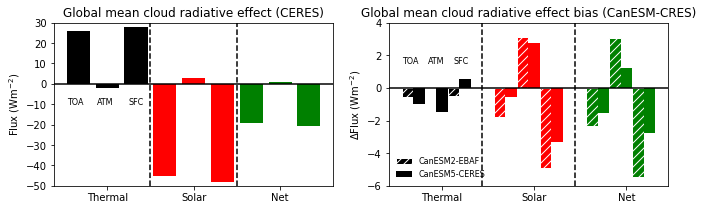

In [6]:
py.figure(figsize=[11,3])

py.subplot(1,2,1)
x_group=np.arange(3)
py.bar(x_group,ebaf_cre_global[:,0],color='k')
x_group=np.arange(3)+3
py.bar(x_group,ebaf_cre_global[:,1],color='r')

x_group=np.arange(3)+6
py.bar(x_group,ebaf_cre_global[:,2],color='g')

py.ylim(-50,30)
py.axhline(color='k')
py.axvline(2.5,color='k',linestyle="--")
py.axvline(5.5,color='k',linestyle="--")

py.xticks((1.0,4.0,7.0),("Thermal","Solar","Net"))
py.text(-0.4,-10,'TOA',fontsize=8)
py.text(0.65,-10,'ATM',fontsize=8)
py.text(1.75,-10,'SFC',fontsize=8)

py.title("Global mean cloud radiative effect (CERES)")
py.ylabel(r"Flux (Wm$^{-2}$)")
# Plot the differences
diff_canesm2 = canesm2_cre_global-ebaf_cre_global
diff_canesm5 = canesm5_cre_global-ebaf_cre_global

py.subplot(1,2,2)
x2_group=np.arange(3)
x5_group=np.arange(3)+0.5
py.bar(x2_group,diff_canesm2[:,0],width=0.5,color='k',fill=True,edgecolor='white',hatch="///",label="CanESM2-EBAF")
py.bar(x5_group,diff_canesm5[:,0],width=0.5,color='k',label="CanESM5-CERES")

x2_group=np.arange(3)+4
x5_group=np.arange(3)+4.5
py.bar(x2_group,diff_canesm2[:,1],width=0.5,color='r',fill=True,edgecolor='white',hatch="///")
py.bar(x5_group,diff_canesm5[:,1],width=0.5,color='r')

x2_group=np.arange(3)+8
x5_group=np.arange(3)+8.5
py.bar(x2_group,diff_canesm2[:,2],width=0.5,color='g',fill=True,edgecolor='white',hatch="///")
py.bar(x5_group,diff_canesm5[:,2],width=0.5,color='g')
py.ylim(-6,4)

py.legend(fontsize=8,loc="lower left",frameon=False)

py.axhline(color='k')
py.axvline(3.25,color='k',linestyle="--")
py.axvline(7.25,color='k',linestyle="--")

py.xticks((1.5,5.5,9.5),("Thermal","Solar","Net"))
py.text(-0.25,1.5,'TOA',fontsize=8)
py.text(0.9,1.5,'ATM',fontsize=8)
py.text(2.0,1.5,'SFC',fontsize=8)
py.title("Global mean cloud radiative effect bias (CanESM-CRES)")
py.ylabel(r"$\Delta$Flux (Wm$^{-2}$)")


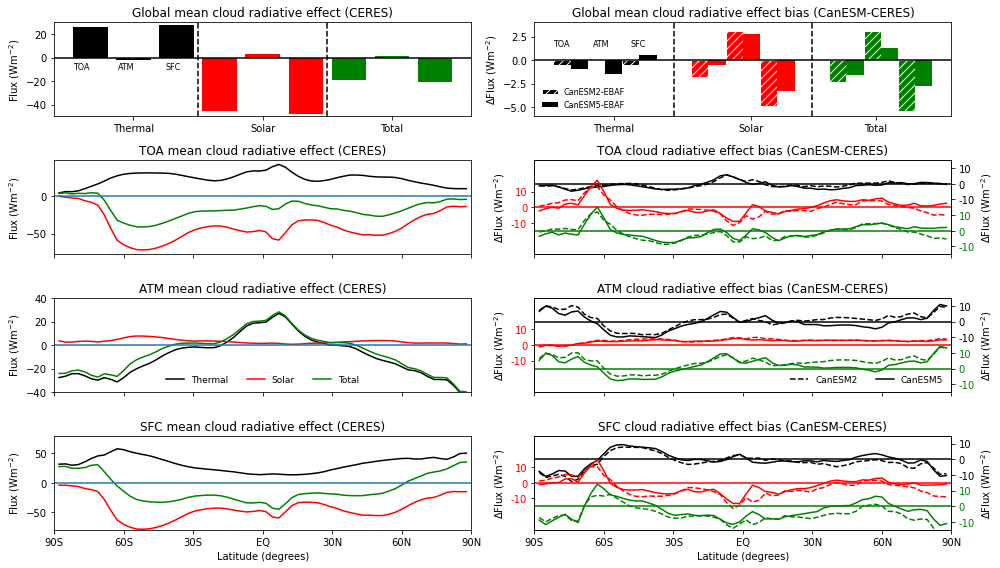

In [11]:
py.figure(figsize=[14,8])

# Plot global
py.subplot(4,2,1)
x_group=np.arange(3)
py.bar(x_group,ebaf_cre_global[:,0],color='k')

x_group=np.arange(3)+3
py.bar(x_group,ebaf_cre_global[:,1],color='r')

x_group=np.arange(3)+6
py.bar(x_group,ebaf_cre_global[:,2],color='g')

py.ylim(-50,30)
py.axhline(color='k')
py.axvline(2.5,color='k',linestyle="--")
py.axvline(5.5,color='k',linestyle="--")

py.xticks((1.0,4.0,7.0),("Thermal","Solar","Total"))
py.text(-0.4,-10,'TOA',fontsize=8)
py.text(0.65,-10,'ATM',fontsize=8)
py.text(1.75,-10,'SFC',fontsize=8)

py.title("Global mean cloud radiative effect (CERES)")
py.ylabel(r"Flux (Wm$^{-2}$)")
# Plot the differences
diff_canesm2 = canesm2_cre_global-ebaf_cre_global
diff_canesm5 = canesm5_cre_global-ebaf_cre_global

py.subplot(4,2,2)
x2_group=np.arange(3)
x5_group=np.arange(3)+0.5
py.bar(x2_group,diff_canesm2[:,0],width=0.5,color='k',fill=True,edgecolor='white',hatch="///",label="CanESM2-EBAF")
py.bar(x5_group,diff_canesm5[:,0],width=0.5,color='k',label="CanESM5-EBAF")

x2_group=np.arange(3)+4
x5_group=np.arange(3)+4.5
py.bar(x2_group,diff_canesm2[:,1],width=0.5,color='r',fill=True,edgecolor='white',hatch="///")
py.bar(x5_group,diff_canesm5[:,1],width=0.5,color='r')

x2_group=np.arange(3)+8
x5_group=np.arange(3)+8.5
py.bar(x2_group,diff_canesm2[:,2],width=0.5,color='g',fill=True,edgecolor='white',hatch="///")
py.bar(x5_group,diff_canesm5[:,2],width=0.5,color='g')
py.ylim(-6,4)

py.legend(fontsize=8,loc="lower left",frameon=False)

py.axhline(color='k')
py.axvline(3.25,color='k',linestyle="--")
py.axvline(7.25,color='k',linestyle="--")

py.xticks((1.5,5.5,9.1),("Thermal","Solar","Total"))
py.text(-0.25,1.5,'TOA',fontsize=8)
py.text(0.9,1.5,'ATM',fontsize=8)
py.text(2.0,1.5,'SFC',fontsize=8)
py.title("Global mean cloud radiative effect bias (CanESM-CERES)")
py.ylabel(r"$\Delta$Flux (Wm$^{-2}$)")

# TOA zonal
py.subplot(4,2,3)
py.plot(ebaf_lat,ebaf_toa_cre[:,0],'k-')
py.plot(ebaf_lat,ebaf_toa_cre[:,1],'r-')
py.plot(ebaf_lat,ebaf_toa_cre[:,2],'g-')
py.xlim(-90,90)
py.xticks((-90,-60,-30,0,30,60,90),())
py.axhline()
py.title("TOA mean cloud radiative effect (CERES)")
py.ylabel(r"Flux (Wm$^{-2}$)")

py.subplot(4,2,4)
py.plot(canesm2_lat,15+(canesm2_toa_cre[:,0]-ebaf_toa_cre[:,0]),'k--')
py.plot(canesm5_lat,15+(canesm5_toa_cre[:,0]-ebaf_toa_cre[:,0]),'k-')
py.axhline(15,color='k')

py.xlim(-90,90)
#py.xticks((-90,-60,-30,0,30,60,90),('90S','60S','30S','EQ','30N','60N','90N'))
py.xticks((-90,-60,-30,0,30,60,90),())
py.ylim(-30,30)
py.yticks((-10,0,10),("-10","0","10"),color='r')
py.ylabel(r"$\Delta$Flux (Wm$^{-2}$)")

ax1=py.twinx()
ax1.plot(canesm2_lat,canesm2_toa_cre[:,1]-ebaf_toa_cre[:,1],'r--')
ax1.plot(canesm5_lat,canesm5_toa_cre[:,1]-ebaf_toa_cre[:,1],'r-')
ax1.axhline(color='r')

ax1.plot(canesm2_lat,-15+(canesm2_toa_cre[:,2]-ebaf_toa_cre[:,2]),'g--')
ax1.plot(canesm5_lat,-15+(canesm5_toa_cre[:,2]-ebaf_toa_cre[:,2]),'g-')
ax1.axhline(-15,color='g')

ax1.set_xlim(-90,90)
ax1.set_ylim(-30,30)

ax1.set_yticks((-25,-15,-5,5,15,25))
ax1.set_yticklabels((-25,-15,-5,5,15,25))
ax1.set_yticklabels(('-10','0','10','-10','0','10'))
labels = ax1.get_yticklabels()
ticks = ax1.get_yticks()
for label, tick in zip(labels, ticks):
  if tick >= 0 :
    label.set_color('k')
  else:
    label.set_color('g')

ax1.set_title("TOA cloud radiative effect bias (CanESM-CERES)")
ax1.set_ylabel(r"$\Delta$Flux (Wm$^{-2}$)")

# Atmosphere zonal

py.subplot(4,2,5)
py.plot(ebaf_lat,ebaf_atm_cre[:,0],'k-',label="Thermal")
py.plot(ebaf_lat,ebaf_atm_cre[:,1],'r-',label="Solar")
py.plot(ebaf_lat,ebaf_atm_cre[:,2],'g-',label="Total")
py.xlim(-90,90)
#py.xticks((-90,-60,-30,0,30,60,90),('90S','60S','30S','EQ','30N','60N','90N'))
py.xticks((-90,-60,-30,0,30,60,90),())
py.ylim(-40,40)
py.axhline()
py.title("ATM mean cloud radiative effect (CERES)")
py.ylabel(r"Flux (Wm$^{-2}$)")
py.legend(loc="lower center",ncol=3,fontsize=9,frameon=False)

py.subplot(4,2,6)
py.plot(canesm2_lat,15+(canesm2_atm_cre[:,0]-ebaf_atm_cre[:,0]),'k--',label="CanESM2")
py.plot(canesm5_lat,15+(canesm5_atm_cre[:,0]-ebaf_atm_cre[:,0]),'k-',label="CanESM5")
py.axhline(15,color='k')
py.xlim(-90,90)
#py.xticks((-90,-60,-30,0,30,60,90),('90S','60S','30S','EQ','30N','60N','90N'))
py.xticks((-90,-60,-30,0,30,60,90),())
py.ylim(-30,30)
py.yticks((-10,0,10),("-10","0","10"),color='r')
py.ylabel(r"$\Delta$Flux (Wm$^{-2}$)")
py.legend(loc="lower right",ncol=2,fontsize=9,frameon=False)

ax1=py.twinx()

ax1.plot(canesm2_lat,canesm2_atm_cre[:,1]-ebaf_atm_cre[:,1],'r--')
ax1.plot(canesm5_lat,canesm5_atm_cre[:,1]-ebaf_atm_cre[:,1],'r-')
ax1.axhline(color='r')

ax1.plot(canesm2_lat,-15+(canesm2_atm_cre[:,2]-ebaf_atm_cre[:,2]),'g--')
ax1.plot(canesm5_lat,-15+(canesm5_atm_cre[:,2]-ebaf_atm_cre[:,2]),'g-')
ax1.axhline(-15,color='g')

ax1.set_xlim(-90,90)
ax1.set_ylim(-30,30)

ax1.set_yticks((-25,-15,-5,5,15,25))
ax1.set_yticklabels((-25,-15,-5,5,15,25))
ax1.set_yticklabels(('-10','0','10','-10','0','10'))
labels = ax1.get_yticklabels()
ticks = ax1.get_yticks()
for label, tick in zip(labels, ticks):
  if tick >= 0 :
    label.set_color('k')
  else:
    label.set_color('g')

ax1.set_title("ATM cloud radiative effect bias (CanESM-CERES)")
ax1.set_ylabel(r"$\Delta$Flux (Wm$^{-2}$)")

# Surface zonal

py.subplot(4,2,7)
py.plot(ebaf_lat,ebaf_sfc_cre[:,0],'k-')
py.plot(ebaf_lat,ebaf_sfc_cre[:,1],'r-')
py.plot(ebaf_lat,ebaf_sfc_cre[:,2],'g-')
py.axhline()
py.xlim(-90,90)
py.xticks((-90,-60,-30,0,30,60,90),('90S','60S','30S','EQ','30N','60N','90N'))
py.xlabel("Latitude (degrees)")
py.ylim(-80,80)
py.title("SFC mean cloud radiative effect (CERES)")
py.ylabel(r"Flux (Wm$^{-2}$)")

py.subplot(4,2,8)

py.plot(canesm2_lat,15+(canesm2_sfc_cre[:,0]-ebaf_sfc_cre[:,0]),'k--')
py.plot(canesm5_lat,15+(canesm5_sfc_cre[:,0]-ebaf_sfc_cre[:,0]),'k-')
py.axhline(15,color='k')
py.xlim(-90,90)
py.xticks((-90,-60,-30,0,30,60,90),('90S','60S','30S','EQ','30N','60N','90N'))
py.xlabel("Latitude (degrees)")
py.ylim(-30,30)
py.yticks((-10,0,10),("-10","0","10"),color='r')
py.ylabel(r"$\Delta$Flux (Wm$^{-2}$)")

ax1=py.twinx()

ax1.plot(canesm2_lat,canesm2_sfc_cre[:,1]-ebaf_sfc_cre[:,1],'r--')
ax1.plot(canesm5_lat,canesm5_sfc_cre[:,1]-ebaf_sfc_cre[:,1],'r-')
ax1.axhline(color='r')

ax1.plot(canesm2_lat,-15+(canesm2_sfc_cre[:,2]-ebaf_sfc_cre[:,2]),'g--')
ax1.plot(canesm5_lat,-15+(canesm5_sfc_cre[:,2]-ebaf_sfc_cre[:,2]),'g-')
ax1.axhline(-15,color='g')

ax1.set_xlim(-90,90)
ax1.set_ylim(-30,30)

ax1.set_yticks((-25,-15,-5,5,15,25))
ax1.set_yticklabels((-25,-15,-5,5,15,25))
ax1.set_yticklabels(('-10','0','10','-10','0','10'))
labels = ax1.get_yticklabels()
ticks = ax1.get_yticks()
for label, tick in zip(labels, ticks):
  if tick >= 0 :
    label.set_color('k')
  else:
    label.set_color('g')

ax1.set_title("SFC cloud radiative effect bias (CanESM-CERES)")
ax1.set_ylabel(r"$\Delta$Flux (Wm$^{-2}$)")

py.tight_layout()

#py.savefig("Cloud_radiative_effect_AMIP_CanESM2_CanESM5_v1.png")